In [1]:
from sklearn.metrics import accuracy_score
from scipy.special import softmax
import calibrator
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

In [2]:
test_data = pd.read_csv('mnist_test.csv')
train_data = pd.read_csv('mnist_train.csv')

FileNotFoundError: [Errno 2] File b'mnist_test.csv' does not exist: b'mnist_test.csv'

In [3]:
y_test = test_data['label']
y_train = train_data['label'][0:48000]
X_test = test_data.drop(columns=['label'])
X_train = train_data.drop(columns=['label'])
X_train = X_train[0:48000][:]
cal = train_data[48000:][:]
y_cal = cal['label']
X_cal = cal.drop(columns=['label'])

In [5]:
clf = MLPClassifier((100, 100,), max_iter=300, random_state=1)
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [6]:
clf.out_activation_ = 'identity'
logits = clf.predict_proba(X_cal)

In [51]:
calibr = calibrator.Calibrator(logits, y_cal)

In [57]:
test_logits = clf.predict_proba(X_test)
test_preds = softmax(test_logits, axis=1)
calibr.compute_ece(15, test_logits, y_test.to_numpy(), len(y_test))

tensor([0.0244])

In [11]:
calibr.ComputeTace(0.9, test_data, test_logits, 15, 'label')

tensor(0.0211, dtype=torch.float64)

In [12]:
calibr.compute_sce(15, 'label', test_logits, test_data)

tensor([0.0025])

In [13]:
calibr.ComputeAce(15, test_data, 'label', test_logits)

tensor(0.0251, dtype=torch.float64)

In [40]:
calibr.TemperatureScaling()
new_logits = calibr.scale_logits_with_temperature(test_logits).detach().numpy()
calibr.compute_ece(15, new_logits, y_test.to_numpy(), len(y_test))

tensor([0.0148])

In [58]:
calibr.ComputeTace(0.9, test_data, new_logits, 15, 'label')


tensor(0.0092, dtype=torch.float64)

In [59]:
calibr.ComputeAce(15, test_data, 'label', new_logits)

tensor(0.0231, dtype=torch.float64)

In [60]:
calibr.compute_sce(15, 'label', new_logits, test_data)

tensor([0.0021])

In [37]:
new_probs = calibrator.multiclass_histogram_binning(15, logits, y_cal.to_numpy(), test_logits)

def SplitIntoBins(m, preds, labels):
    bins = []
    true_labels_for_bins = []
    for i in range(m):
            bins.append([])
            true_labels_for_bins.append([])
    for j in range(len(labels)):
            max_p = max(preds[j])
            for i in range(m):
                if i/m < max_p and max_p <= (i+1)/m:
                    bins[i].append((preds[j]))
                    true_labels_for_bins[i].append(labels[j])
    return bins, true_labels_for_bins

def ComputeEce(m, preds, labels):
    bins, true_labels_for_bins = SplitIntoBins(m, preds, labels)
    accuracies = []
    confidences = []
    ece = 0
    bins = list(filter(None, bins))
    true_labels_for_bins = list(filter(None, true_labels_for_bins))
    for i in range(len(bins)):
        accuracy = accuracy_score(true_labels_for_bins[i], np.argmax(bins[i], axis=1))
        accuracies.append(accuracy)
        max_pi = sum(np.amax(bins[i], axis = 1))
        confidences.append(max_pi/len(bins[i]))
        ece += len(bins[i]) * abs(accuracies[i] - confidences[i])/2897
    return ece
ComputeEce(15, new_probs, y_test.to_numpy())

0.01349574089747102

In [41]:
y_true = []
for i in range(10):
    y_true.append([])
for i in range(10):
    for label in y_test:
        if label == i:
            y_true[i].append(1)
        else:
            y_true[i].append(0)                    

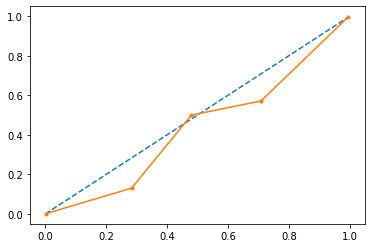

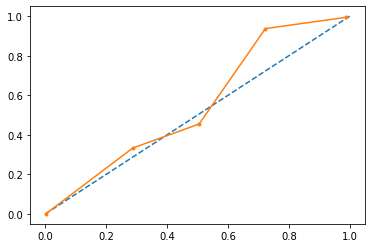

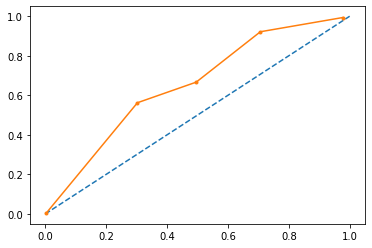

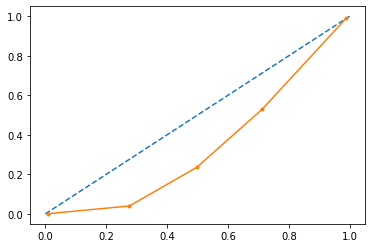

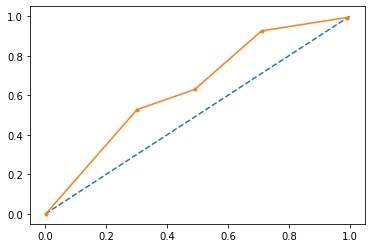

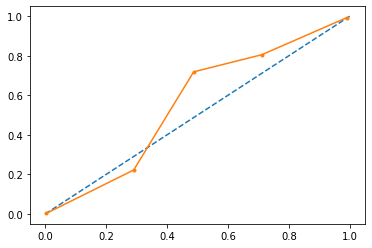

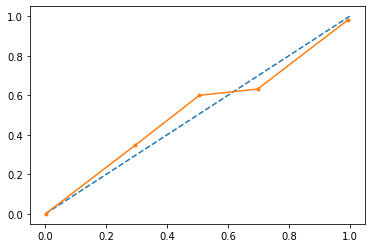

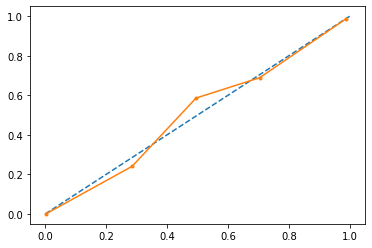

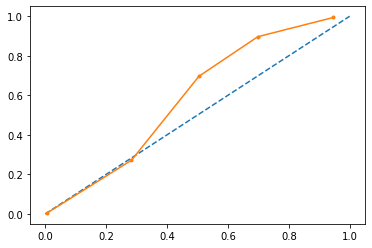

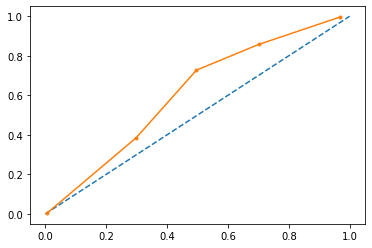

In [45]:
new_predictions = np.transpose(softmax(new_logits, axis=1))
for i in range(10):
    fop, mpv = calibration_curve(y_true[i], new_predictions[i])
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(mpv, fop, marker='.')
    plt.show() 

In [ ]:
calibr.MatrixScaling()
new_logits = calibr.matrix_scaling_logits(test_logits).detach().numpy()
calibr.compute_ece(15, new_logits, y_test.to_numpy(), len(y_test))

In [ ]:
calibr.VectorScaling()
new_logits = calibr.vector_scaling_logits(test_logits).detach().numpy()
calibr.compute_ece(15, new_logits, y_test.to_numpy(), len(y_test))